In [42]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [43]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

<module 'models' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\GitHubRep\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\dataset.pkl', map_location=device)

cpu


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13496\295618481.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(r'c:\Users\Usuario\Documents\Documents

In [91]:
# Get the first graph in the dataset
data = dataset[59].clone()

In [92]:
#data = dataset[10].clone()

In [93]:
data

Data(x=[180, 4], edge_index=[2, 3718], file='DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', frame_mask=[180], behaviour=[11], behaviour_names=Index(['General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R',
       'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V',
       'Rearing_V', 'Grooming_V'],
      dtype='object'))

In [94]:
data.behaviour_names

Index(['General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R',
       'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V',
       'Rearing_V', 'Grooming_V'],
      dtype='object')

In [95]:
data.frame_mask

tensor([59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61,
        62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59,
        60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62,
        63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60,
        61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63,
        59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61,
        62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59,
        60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62,
        63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60,
        61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63],
       dtype=torch.int32)

In [96]:
node_features = data.x
edge_index = data.edge_index
frame_mask = data.frame_mask

In [97]:
def is_undirected(edge_index):
    # Sort the edges to ensure each pair (u, v) and (v, u) is in the same order.
    sorted_edges = edge_index.t().sort(dim=1)[0]
    
    # Find unique edges and count their occurrences.
    unique_edges, counts = torch.unique(sorted_edges, dim=0, return_counts=True)
    
    # For the graph to be undirected, each unique edge should appear twice.
    return torch.all(counts == 2), unique_edges, counts

flag, unique_edges, counts = is_undirected(edge_index)



In [98]:
print(counts.unique())

tensor([1, 2])


In [99]:
# print the edges that have other than 2 counts and their counts
print(len(unique_edges[counts == 2]))

1769


In [100]:
edge_index = edge_index.numpy()

In [101]:
# Plot the graph
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G1 = nx.Graph()
G.add_nodes_from(range(node_features.shape[0]))
G1.add_nodes_from(range(node_features.shape[0]))
edge_color = []
edge1_color = []
edges = []
for edge in edge_index.T:
    #if node_features[edge[0], 4] != node_features[edge[1], 4]:
    if frame_mask[edge[0]] != frame_mask[edge[1]]:
        G1.add_edge(edge[0], edge[1], color='y')
        edges.append((edge[0], edge[1]))
        edge1_color.append('y')
        print('r')
    else:
        edges.append((edge[0], edge[1]))
        G.add_edge(edge[0], edge[1], color='k')
        edge_color.append('k')

#G.add_edges_from(edge_index.T.tolist())

r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r


In [102]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179))

In [103]:
node_features[:,3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [104]:
data.frame_mask

tensor([59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61,
        62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59,
        60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62,
        63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60,
        61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63,
        59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61,
        62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59,
        60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62,
        63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60,
        61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62, 63],
       dtype=torch.int32)

In [105]:
# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
# Put different colors to the nodes depending on the node features
colors = node_features[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'b' for c in colors]

# Node sizes
size = 100
# alpha of the edges
alpha = 0.3
# Position of the nodes
pos = node_features[:, :2].numpy()
# Add data.frame_mask to the x coordinate
# Frame difference
frame_x_diff = data.frame_mask.numpy().copy()
# Normalize the frame difference
frame_x_diff = ((frame_x_diff - frame_x_diff.min())*2) / (frame_x_diff.max() - frame_x_diff.min())
pos[:, 0] += frame_x_diff


In [106]:
frame_x_diff

array([0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5,
       1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ,
       0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5,
       1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ,
       0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ])

In [107]:
pos

array([[0.80658126, 0.393025  ],
       [1.3021547 , 0.43483126],
       [1.7960827 , 0.47045   ],
       [2.2949593 , 0.48894793],
       [2.770886  , 0.50371665],
       [0.82131094, 0.32279792],
       [1.3213906 , 0.37240416],
       [1.8219438 , 0.39786458],
       [2.3219438 , 0.42061043],
       [2.8219438 , 0.45206457],
       [0.77657187, 0.35134375],
       [1.2743454 , 0.3883604 ],
       [1.7729781 , 0.41701874],
       [2.272978  , 0.4251521 ],
       [2.772978  , 0.44064793],
       [0.80985   , 0.35539374],
       [1.3007016 , 0.39979374],
       [1.7985203 , 0.4328271 ],
       [2.2985203 , 0.4576771 ],
       [2.7887454 , 0.4712125 ],
       [0.8072719 , 0.26305208],
       [1.3184421 , 0.30724582],
       [1.8325531 , 0.33384582],
       [2.335197  , 0.36172083],
       [2.835197  , 0.39949584],
       [0.7533984 , 0.33097917],
       [1.2533984 , 0.34882918],
       [1.7533984 , 0.37240207],
       [2.2540672 , 0.38610834],
       [2.7545235 , 0.38884374],
       [0.

In [108]:
# count values of data.frame_mask.numpy()
unique, counts = np.unique(data.frame_mask.numpy(), return_counts=True)
dict(zip(unique, counts))


{59: 36, 60: 36, 61: 36, 62: 36, 63: 36}

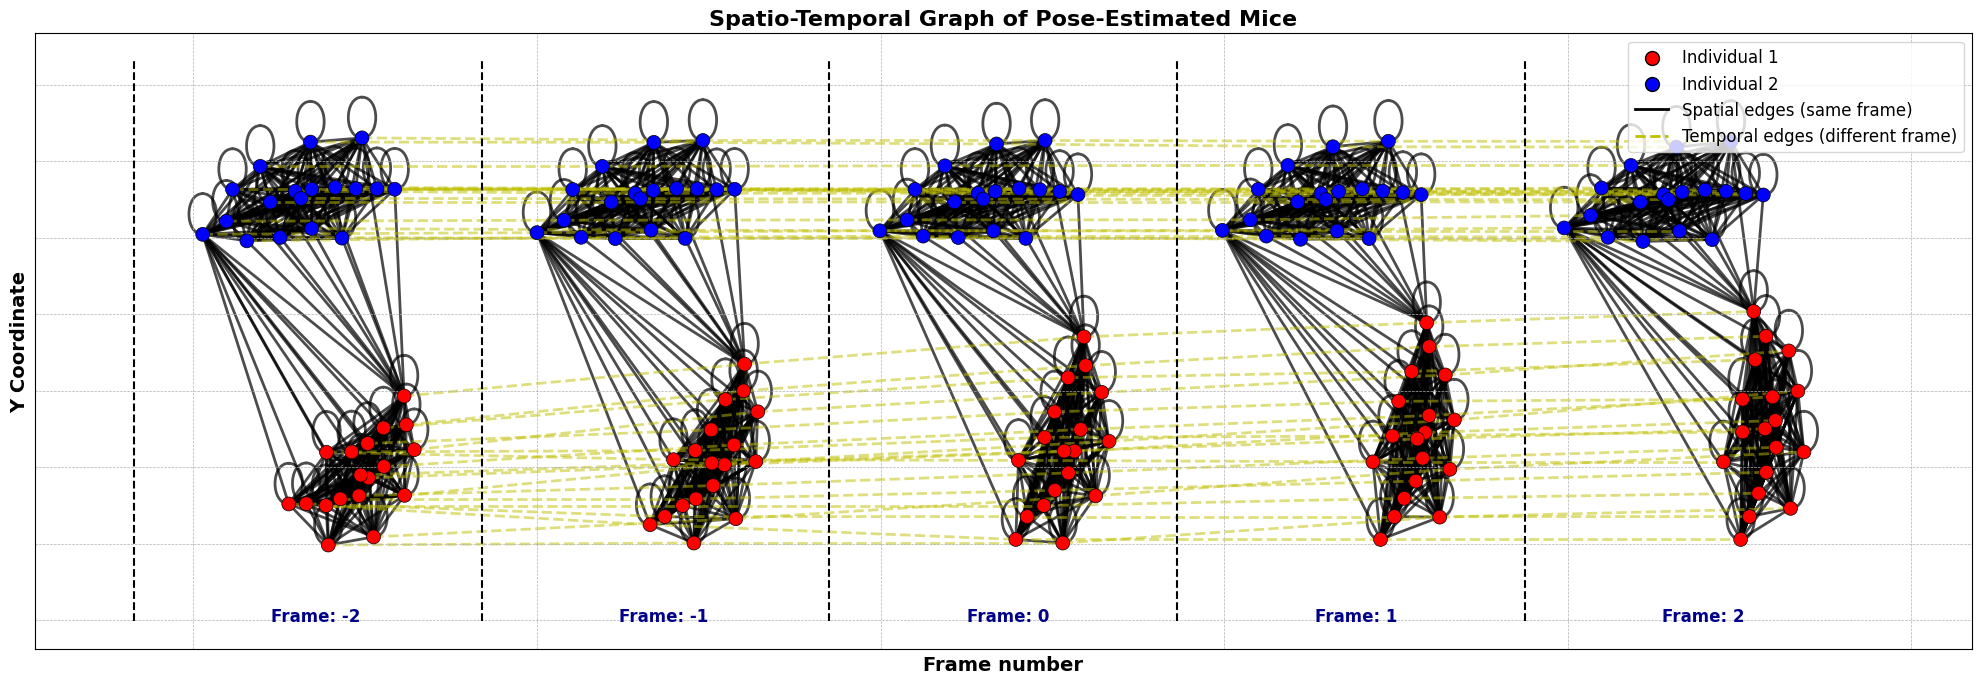

In [111]:
# Plot the graph
plt.figure(figsize=(25, 8))

# Draw edges with different colors and alpha values
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_color, width=2)
nx.draw_networkx_edges(G1, pos, alpha=0.5, edge_color=edge1_color, width=2, style='dashed')

# Draw nodes with different colors and sizes
node_sizes = [size if color == 'r' else size for color in colors]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, edgecolors='k', linewidths=0.5)

# Add legend for the nodes
plt.scatter([], [], c='r', label='Individual 1', s=100, edgecolors='k')
plt.scatter([], [], c='b', label='Individual 2', s=100, edgecolors='k')

# Add legend for the edges
plt.plot([], [], c='k', label='Spatial edges (same frame)', linewidth=2)
plt.plot([], [], c='y', label='Temporal edges (different frame)', linewidth=2, linestyle='dashed')

# Plot a discrete x-axis to show the frames
centers = np.arange(pos[:, 0].min() - 0.1, pos[:, 0].max() + 0.1, (pos[:, 0].max() - pos[:, 0].min() + 0.2) / 5)
frames = ['Frame: -2', 'Frame: -1', 'Frame: 0', 'Frame: 1', 'Frame: 2']

num_frames = 5
for i in range(num_frames):
    plt.text(centers[i] + 0.2, pos[:, 1].min() - 0.1, frames[i], fontsize=12, fontweight='bold', color='darkblue')
    plt.plot([centers[i], centers[i]], [pos[:, 1].min() - 0.1, pos[:, 1].max() + 0.1], 'k--')

# Indicate the frame number
plt.xlabel('Frame number', fontsize=14, fontweight='bold')
plt.ylabel('Y Coordinate', fontsize=14, fontweight='bold')

# Center the x-axis
plt.legend(loc='upper right', fontsize=12)
plt.title('Spatio-Temporal Graph of Pose-Estimated Mice', fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [110]:
# Lets only plot the nodes that are in a same frame
nodes_features_to_keep = node_features[node_features[:,4]==0]

IndexError: index 4 is out of bounds for dimension 1 with size 4

In [ ]:
nodes_features_to_keep.shape

In [820]:
# edge_index of the nodes that are in the same frame
G = nx.Graph()

# Get the indices of the nodes that are in the same frame
nodes_in_frame = np.where(node_features[:,4]==0)[0]
nodes_features_to_keep = node_features[node_features[:,4]==0]

G.add_nodes_from(nodes_in_frame)

edge_index = edge_index.numpy()

# Keep only the edges that are between nodes in the same frame
for i in range(edge_index.shape[1]):
    if edge_index[0, i] in nodes_in_frame and edge_index[1, i]in nodes_in_frame:
        G.add_edge(edge_index[0, i], edge_index[1, i])



In [ ]:
G.number_of_nodes()

In [ ]:
G.edges

In [ ]:
nodes_in_frame

In [ ]:
edge_index

In [ ]:
G.nodes

In [ ]:
edge_index[0, 0]
edge_index[1, 0]

In [ ]:
nodes_features_to_keep[:,:2].numpy()

In [ ]:


# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
pos = node_features[:, :2].numpy()
# mappi
colors = nodes_features_to_keep[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'y' for c in colors]

# Plot
plt.figure(figsize=(25, 8))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()



## Just Loading a model

In [44]:
import torch
import importlib

In [45]:
# Load the model
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return model, optimizer, epoch

In [46]:
checkpoint = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\runs\new_encoder_no_linearResCon\Dominance_R\checkpoint_epoch_190.pth', map_location='cpu')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_25224\1808905599.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r'c:\Users\Usuario\Documents\Docum

In [48]:
checkpoint['epoch']

30

In [30]:
import models
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [41]:
graphencoder = models.GATEncoder_vfollowing(8, 16, 2, 4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=576, nhid = 32, nout = 2)

In [42]:
readout = 'concatenate'
model = models.GraphClassifier(graphencoder, class_head, readout= readout)

In [43]:
for key in checkpoint['model_state_dict']:
    print(key, checkpoint['model_state_dict'][key].shape)

encoder.gatenc1.att torch.Size([1, 2, 16])
encoder.gatenc1.bias torch.Size([32])
encoder.gatenc1.lin_l.weight torch.Size([32, 4])
encoder.gatenc1.lin_l.bias torch.Size([32])
encoder.gatenc1.lin_r.weight torch.Size([32, 4])
encoder.gatenc1.lin_r.bias torch.Size([32])
encoder.gatenc2.att torch.Size([1, 2, 16])
encoder.gatenc2.bias torch.Size([32])
encoder.gatenc2.lin_l.weight torch.Size([32, 32])
encoder.gatenc2.lin_l.bias torch.Size([32])
encoder.gatenc2.lin_r.weight torch.Size([32, 32])
encoder.gatenc2.lin_r.bias torch.Size([32])
encoder.gatenc3.att torch.Size([1, 2, 16])
encoder.gatenc3.bias torch.Size([16])
encoder.gatenc3.lin_l.weight torch.Size([32, 32])
encoder.gatenc3.lin_l.bias torch.Size([32])
encoder.gatenc3.lin_r.weight torch.Size([32, 32])
encoder.gatenc3.lin_r.bias torch.Size([32])
encoder.res_conn.0.weight torch.Size([32, 32])
encoder.res_conn.0.bias torch.Size([32])
classifier.hidden1.weight torch.Size([32, 576])
classifier.hidden1.bias torch.Size([32])
classifier.hidden2

In [44]:
# Print shapes of the model
for name, param in model.named_parameters():
    print(name, param.shape)

encoder.gatenc1.att torch.Size([1, 2, 16])
encoder.gatenc1.bias torch.Size([32])
encoder.gatenc1.lin_l.weight torch.Size([32, 4])
encoder.gatenc1.lin_l.bias torch.Size([32])
encoder.gatenc1.lin_r.weight torch.Size([32, 4])
encoder.gatenc1.lin_r.bias torch.Size([32])
encoder.gatenc2.att torch.Size([1, 2, 16])
encoder.gatenc2.bias torch.Size([32])
encoder.gatenc2.lin_l.weight torch.Size([32, 32])
encoder.gatenc2.lin_l.bias torch.Size([32])
encoder.gatenc2.lin_r.weight torch.Size([32, 32])
encoder.gatenc2.lin_r.bias torch.Size([32])
encoder.gatenc3.att torch.Size([1, 2, 16])
encoder.gatenc3.bias torch.Size([16])
encoder.gatenc3.lin_l.weight torch.Size([32, 32])
encoder.gatenc3.lin_l.bias torch.Size([32])
encoder.gatenc3.lin_r.weight torch.Size([32, 32])
encoder.gatenc3.lin_r.bias torch.Size([32])
encoder.res_conn.0.weight torch.Size([32, 32])
encoder.res_conn.0.bias torch.Size([32])
classifier.hidden1.weight torch.Size([32, 576])
classifier.hidden1.bias torch.Size([32])
classifier.hidden2

In [45]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [46]:
# count parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

25362


---

---

# Visualization of validation accuracy per epoch.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [18]:
path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\runs\new_encoder_no_linearResCon\Rearing_R\Oct17_13-56-35\csv.csv'

df = pd.read_csv(path)

In [19]:
df.drop(columns=['Wall time'], inplace=True)

In [4]:
df.tail()

,Step,Value
193,193,0.774800
194,194,0.766347
195,195,0.765850
196,196,0.758514
197,197,0.766550


In [105]:
# Eliminate rows 180 and 181 
df.drop([180, 181], inplace=True)



In [20]:
steps = df['Step']
values = df['Value']

In [21]:
# keep only each 10 epochs
steps = steps[::10]
values = values[::10]


In [22]:
steps

0        0
10      10
20      20
30      30
40      40
50      50
60      60
70      70
80      80
90      90
100    100
110    110
120    120
130    130
140    140
150    150
160    160
170    170
180    180
190    190
200    200
Name: Step, dtype: int64

In [23]:
import seaborn as sns



In [24]:
max_value = values.max()
max_step = steps[values.idxmax()]

print(f"Max value: {max_value} at step {max_step}")

Max value: 0.6643953323364258 at step 170


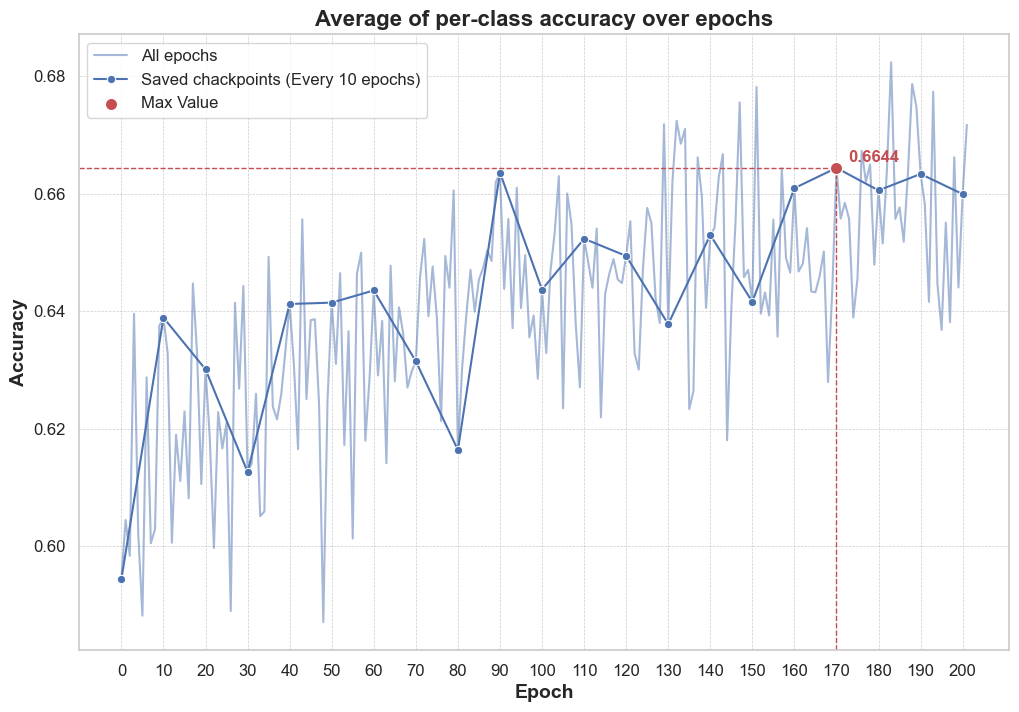

In [29]:
# Set the style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(df['Step'], df['Value'], alpha = 0.5, label = 'All epochs')
sns.lineplot(x=steps, y=values, marker='o', color='b', label = 'Saved chackpoints (Every 10 epochs)')

# Add labels and title
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Average of per-class accuracy over epochs', fontsize=16, fontweight='bold')

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# The reference in the x axis each 10 epochs
plt.xticks(steps)


# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Trace lines on the max value
plt.axvline(x=max_step, color='r', ymax=0.78, linestyle='--', linewidth=1)
plt.axhline(y=max_value, color='r', xmax=0.82, linestyle='--', linewidth=1)

# Indicate the max value
plt.text(max_step+15, max_value+0.001, f'{max_value:.4f}', color='r', fontsize=12, fontweight='bold', ha='right')

# Add a marker for the max value
plt.scatter(max_step, max_value, color='r', s=80, zorder=5, edgecolors='w', label='Max Value')

plt.legend(fontsize=12)
# Show the plot
plt.show()


---
---

# Confussion martices for GAT models

In [3]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader, DataListLoader
import tqdm
import time
import augmentation
import sklearn

In [4]:
# Import f1_score and matthews_corrcoef from sklearn
from sklearn.metrics import f1_score, matthews_corrcoef


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pickle as pkl

In [5]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()



cpu


In [172]:
# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\datasets\dataset_5.pkl', map_location=device)

#Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
    #    'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
    #    'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
    #    'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
    #    'Grooming_V'],
    #   dtype='object')
# Select the behaviour to classify (Grooming in this case)
indx_behaviour1 = 1
indx_behaviour2 = 9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7948\3495851784.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(r'c:\Users\Usuario\Documents\Documents

In [173]:
# Select the behaviour to classify
name_behaviour = dataset[0].behaviour_names[indx_behaviour1]
print(f"Behaviour selected: {name_behaviour}")

# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)

# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]


Behaviour selected: Sniffing_R


In [174]:
for i in range(len(test_dataset)):
    test_dataset[i].behaviour = test_dataset[i].behaviour[indx_behaviour1]
print('Done selecting the behaviour')

print('The test dataset has %d samples' % len(test_dataset))


Done selecting the behaviour
The test dataset has 62016 samples


In [175]:
batch_size = 64

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


c:\Users\Usuario\anaconda3\envs\envProj\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [176]:
graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_heads = 2, n_in = 4, n_layers=4, dropout=0.2)
class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)

readout = 'mean'
model = models.GraphClassifier(graphencoder, class_head, readout=readout)

In [177]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
metric_0 = f1_score
metric_1 = matthews_corrcoef


In [178]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return epoch


In [179]:
checkpoint_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Checkpoints\new_encoder_no_linearResCon\Sniffing_R\checkpoint_epoch_150.pth'
actual_epoch = load_checkpoint(model, optimizer, checkpoint_path)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7948\1992117850.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


Checkpoint loaded from c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Checkpoints\new_encoder_no_linearResCon\Sniffing_R\checkpoint_epoch_150.pth, at epoch 150


In [180]:
model.eval()
val_loss = 0
correct = 0
correct_class_0 = 0
correct_class_1 = 0
total_class_0 = 0
total_class_1 = 0
total = 0
with torch.no_grad():
    for val_data in tqdm.tqdm(test_loader):
        val_outputs = model(val_data)
        val_labels = val_data.behaviour
        val_predicted = val_outputs.argmax(dim=1)
        correct_class_0 += (val_predicted[val_labels == 0] == val_labels[val_labels == 0]).sum().item()
        correct_class_1 += (val_predicted[val_labels == 1] == val_labels[val_labels == 1]).sum().item()
        total_class_0 += (val_labels == 0).sum().item()
        total_class_1 += (val_labels == 1).sum().item()
        correct += (val_predicted == val_labels).sum().item()
        total += val_labels.size(0)

100%|██████████| 969/969 [10:04<00:00,  1.60it/s]


In [183]:
val_accuracy = correct / total
print(f'Accuracy of the network on the test set: {100 * val_accuracy:.2f}%')

val_accuracy_class_0 = correct_class_0 / total_class_0
val_accuracy_class_1 = correct_class_1 / total_class_1
print(f'Accuracy of the network on the test set for class 0: {100 * val_accuracy_class_0:.2f}%')
print(f'Accuracy of the network on the test set for class 1: {100 * val_accuracy_class_1:.2f}%')

avg_val_accuracy = (val_accuracy_class_0 + val_accuracy_class_1) / 2
print(f'Average accuracy of the network on the test set: {100 * avg_val_accuracy:.2f}%')


Accuracy of the network on the test set: 69.90%
Accuracy of the network on the test set for class 0: 88.50%
Accuracy of the network on the test set for class 1: 48.82%
Average accuracy of the network on the test set: 68.66%


In [ ]:
# Build the confusion matrix
cm = np.array([[


tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0])

tensor(0.6875)

In [162]:

val_labels = torch.cat(val_labels, dim=0).cpu().numpy()
val_preds = torch.cat(val_preds, dim=0).cpu().numpy()


In [163]:
len(val_labels)
len(val_preds)

62016

In [135]:
# Compute the metrics
f1_class_0 = metric_0(val_labels, val_preds, average='macro')
mcc = metric_1(val_labels, val_preds)

print(f'F1 Score (Class 0): {f1_class_0:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')


F1 Score (Class 0): 0.6805
Matthews Correlation Coefficient: 0.4096


In [164]:
# Confusion matrix
cm= sklearn.metrics.confusion_matrix(val_labels, val_preds)


In [165]:
cm

array([[29120,  3820],
       [14451, 14625]], dtype=int64)

In [ ]:
i

In [2]:
import pickle as pkl

In [13]:
# Loqd pkl file

path = r'c:\Users\Usuario\Downloads\results_epoch_150.pkl'

with open(path, 'rb') as f:
    metrics = pkl.load(f)

metrics


{'correct': 53740,
 'total': 62016,
 'val_accuracy': 0.8665505675954592,
 'correct_class_0': 27192,
 'correct_class_1': 26548,
 'total_class_0': 32940,
 'total_class_1': 29076,
 'val_accuracy_class_0': 0.8255009107468124,
 'val_accuracy_class_1': 0.9130554409134681}

In [ ]:


cm = np.array([[metrics['correct_class_0'], metrics['total_class_0'] - metrics['correct_class_0']], [metrics['total_class_1'] - metrics['correct_class_1'], metrics['correct_class_1']]])

cm

In [8]:
# Normalize the confusion matrix

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

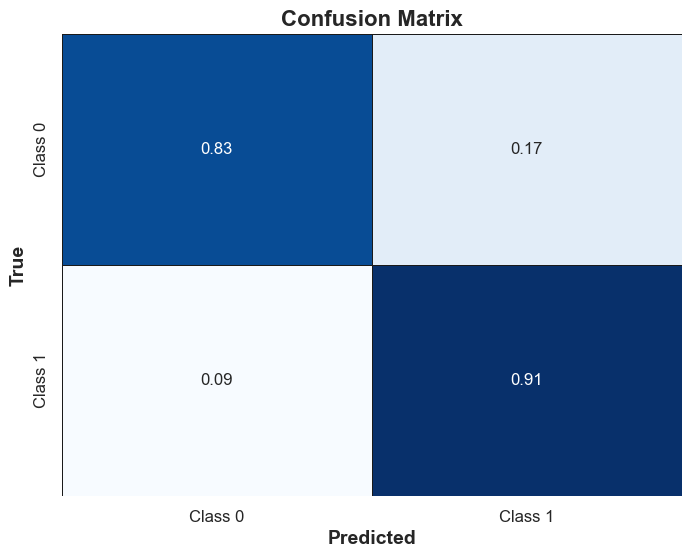

In [12]:
# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt = '.2f', annot_kws={"size": 12}, cmap='Blues', cbar=False, linewidths=0.5, linecolor='k')
             

# Add labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('True', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

# Customize the ticks
plt.xticks([0.5, 1.5], ['Class 0', 'Class 1'], fontsize=12)
plt.yticks([0.5, 1.5], ['Class 0', 'Class 1'], fontsize=12)

# Show the plot
plt.show()


---
---

# Classes Balances

In [6]:
# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\datasets\dataset_5.pkl', map_location=device)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_4460\1833403735.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(r'c:\Users\Usuario\Documents\Documents

In [51]:
# Select behaviour
behaviour_idx = 0


print(dataset[0].behaviour_names[behaviour_idx])

label = []
for i in range(len(dataset)):
    label.append(dataset[i].behaviour[behaviour_idx])

General_Contacts


In [52]:
# Balance
unique, counts = np.unique(label, return_counts=True)
print('Unique labels:', unique)
print('Counts:', counts)

print("The percentage of the minority class is: ", counts[1] / counts.sum())

Unique labels: [0 1]
Counts: [153439 156638]
The percentage of the minority class is:  0.5051583961403135
